***
# Day2からの変更点

***
- nehotベクトルによる説明変数の追加
- 決定木による分析　
- ニューラルネットワークの分析
<BR>

In [11]:
# ライブラリのインポート
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import mean_absolute_error # 回帰問題における性能評価に関する関数
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [12]:
# ファイルのインポート
df_kick = pd.read_csv("./ks-projects-201801.csv")

In [22]:
# データ構成の把握
print(df_kick.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB
None


***
# 項目概要
***
- ID:kickstarter ID
- name:プロジェクト名
- category:カテゴリ
- main_category:メインカテゴリ
- currency:ファンディング使用通貨
- deadline:締切日
- goal:目標金額
- launched:開始日
- pledged:集めた金額
- state:状況
- backers:支援者数
- country:どの国からのクラウドファンディングか
- usd_pledged:集まった金額のUSD換算値(KS)
- usd_real_pledged:集まった金額のUSD換算値(fixer)
- usd_goal_real:目標金額のUSD換算


***
# 分析の方針
***
説明変数は一定限られており、以下の項目の前処理を具体的に検討する。<BR>

【特徴量の初期仮説】<BR>
- goal     : 金額が小さい方が成功しやすいのではないか
- deadline : 調達までの期間が長い方が成功しやすいのではないか
- category : 成功しやすいカテゴリと成功しづらいカテゴリがあり見極めが必要
- main_category : 上記同様
- currency : 通貨　→成功しやすい通貨と成功しづらい通貨があり見極めが必要。おそらくドルが強い
- country  : 国　　→成功しやすい国と成功しづらい国があり見極めが必要。おそらくUSが強い
- name     : 文字数とか記号の数とか、成功しやすいキーワードとかあるかもしれない。






In [15]:
#データの中身の参照
df_kick.head(n=5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [16]:
#データの平均等の把握
df_kick.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [ ]:
#散布図による確認
pd.plotting.scatter_matrix(df_kick, figsize=(15,15))
plt.show()

In [ ]:
#ヒートマップでの把握
plt.figure(figsize=(12,10))
sns.heatmap(df_kick.corr(), annot=True)
plt.show()

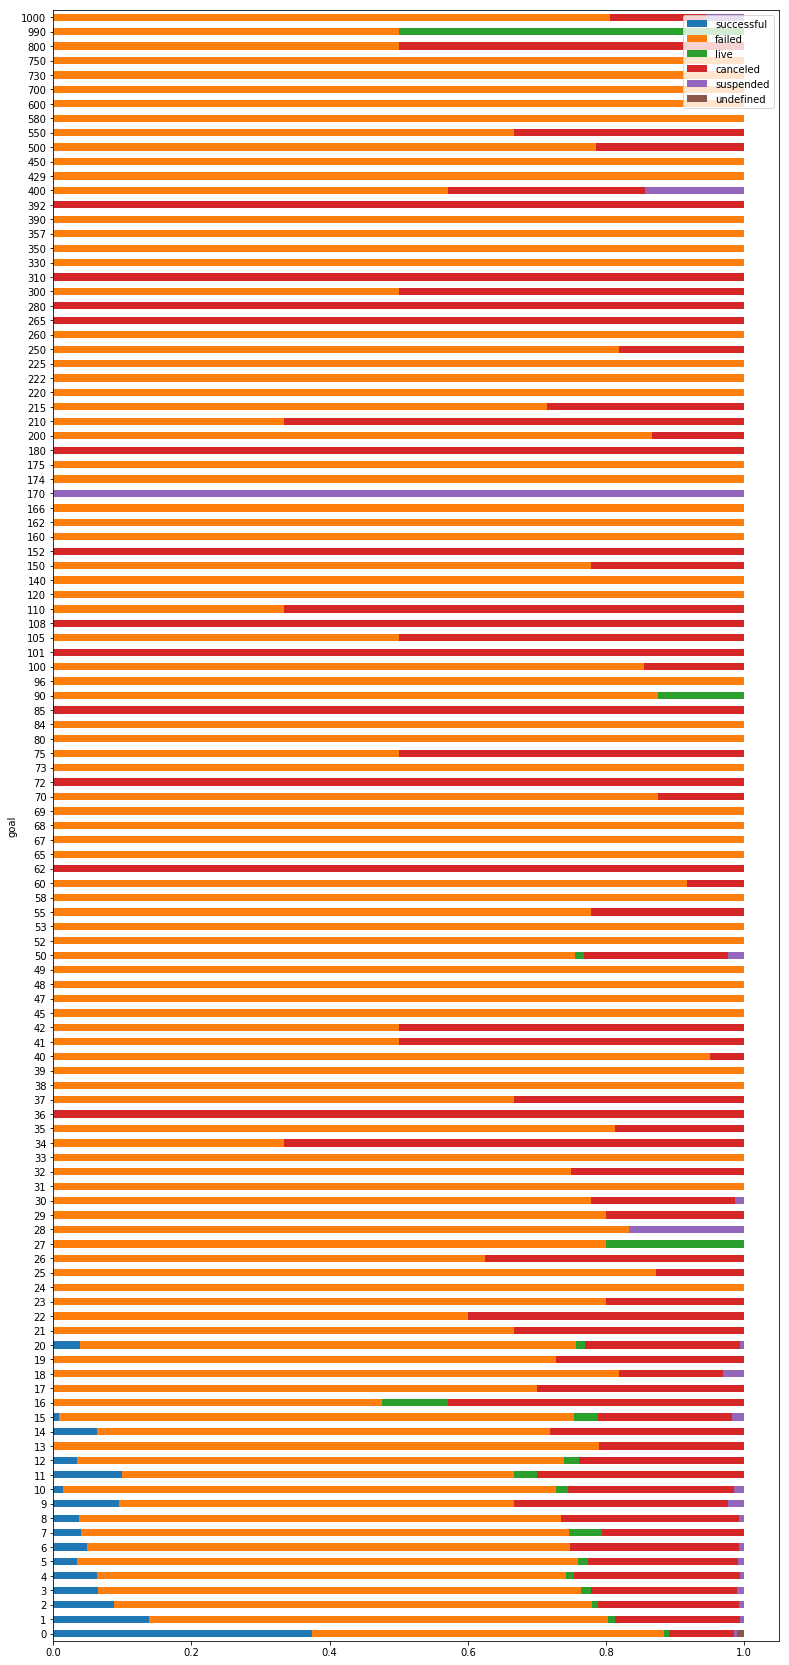

In [29]:
# goal毎のstateを確認する
# 初期化説の通り、低額の方が成功しやすい
df_kick=df_kick.copy()
df_kick['goal']=df_kick['goal'].apply(lambda x: round(x/100000))
goal=df_kick.groupby('goal')
goal=goal['state'].value_counts(normalize=True).unstack()
ax=goal[['successful','failed','live','canceled','suspended','undefined']].plot(kind='barh',stacked=True,figsize=(13,30))
plt.legend(loc='upper right')

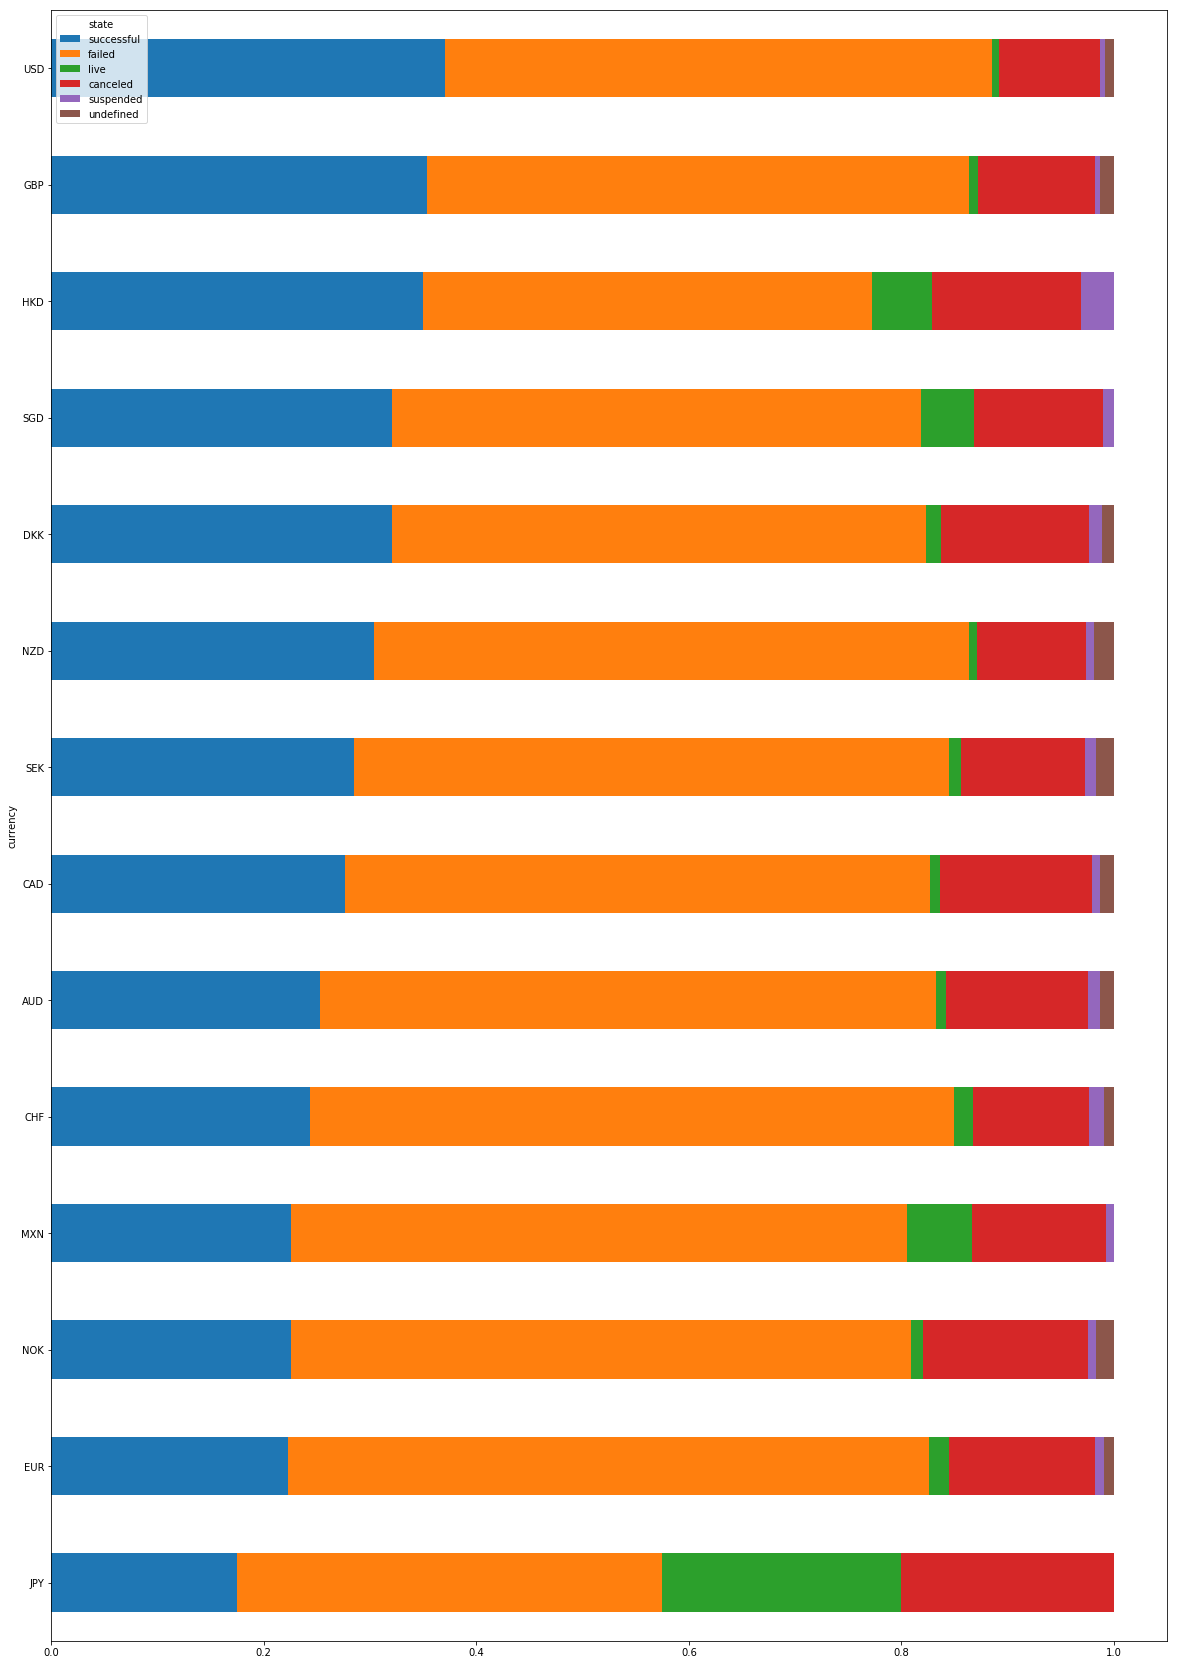

In [28]:
# currency毎のstateを確認する
# 想定通り、USDやポンド等の調達しやすい通貨が強い。
# 日本円は現在は獲得しづらいがLiveが多い為、現在は増加傾向になっているかもしれない。
currency=df_kick.groupby('currency')
currency=currency['state'].value_counts(normalize=True).unstack()
currency=currency.sort_values(by=['successful'],ascending=True)
currency[['successful','failed','live','canceled','suspended','undefined']].plot(kind='barh',stacked=True,figsize=(20,30))

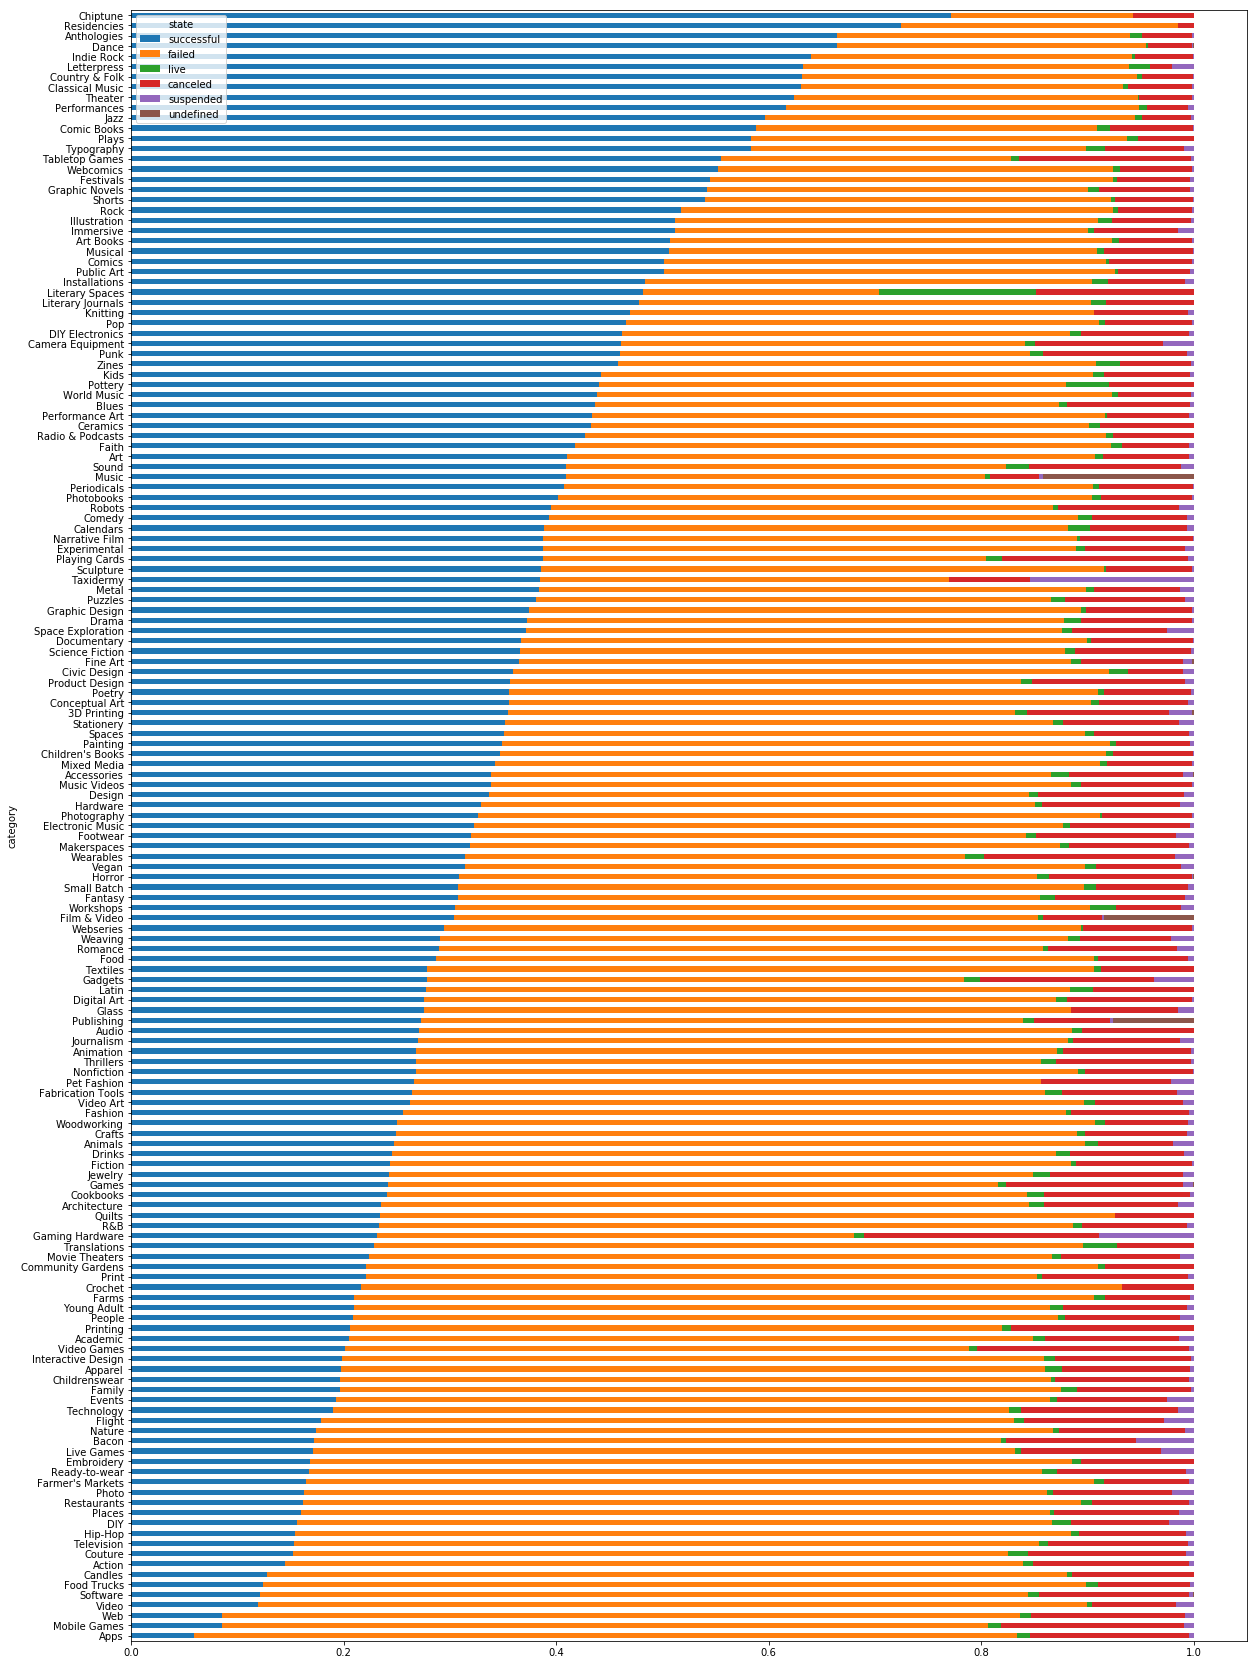

In [27]:
# category毎のstateを確認する
# 成功しやすいカテゴリと、しづらいカテゴリがあることが明確になっている
# 音楽関連が強く、スマホゲームやTVは成功率が低いのは世間全般的なイメージの影響があるのか。
# とはいえComicやTabletopGameが高いのはなぜか
# プロジクト内容があれば、トピックモデルとかを使って別の有力な説明変数が作れるのではないか

category=df_kick.groupby('category')
category=category['state'].value_counts(normalize=True).unstack()
category=category.sort_values(by=['successful'],ascending=True)
category[['successful','failed','live','canceled','suspended','undefined']].plot(kind='barh',stacked=True,figsize=(20,30))

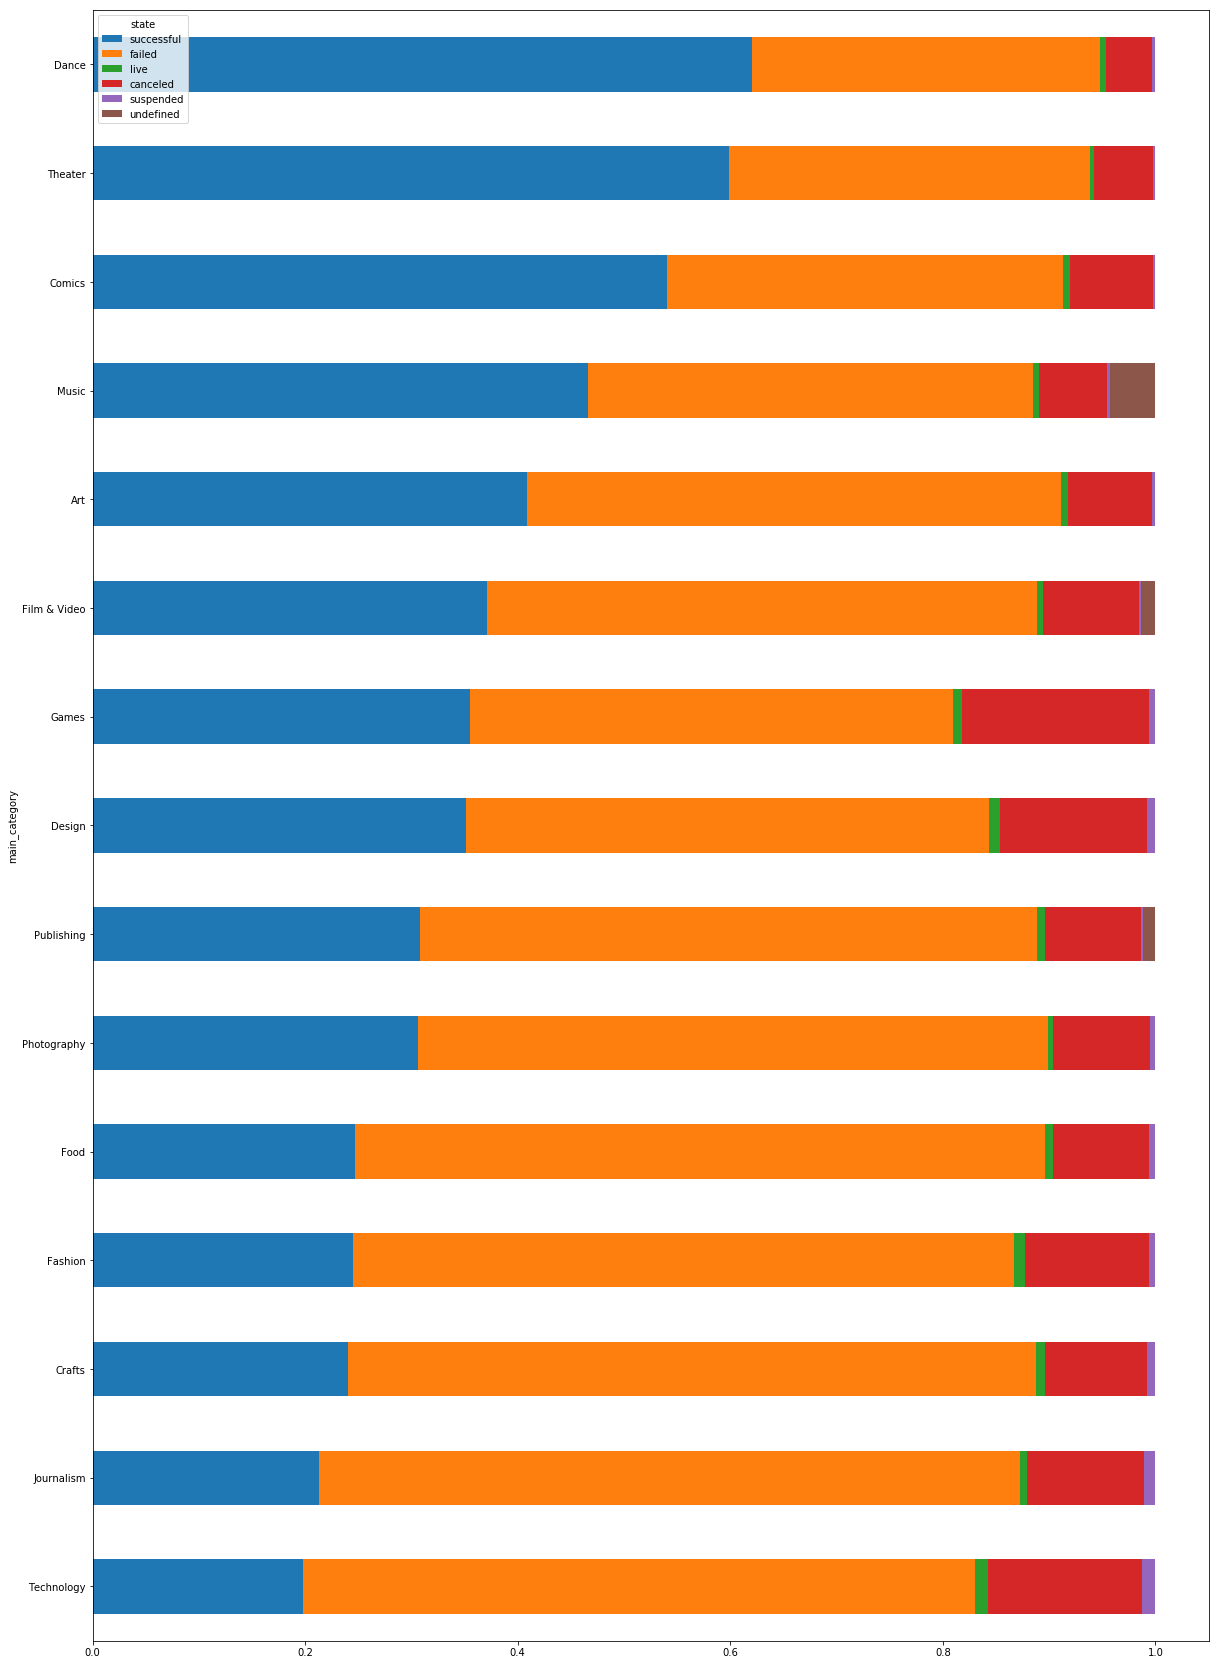

In [30]:
# main_category毎のstateを確認する
# 成功しやすいカテゴリと、しづらいカテゴリがあることが明確になっている
# なぜDanceが成功しやすいかは、仮説も立たない。。。

main_category=df_kick.groupby('main_category')
main_category=main_category['state'].value_counts(normalize=True).unstack()
main_category=main_category.sort_values(by=['successful'],ascending=True)
main_category[['successful','failed','live','canceled','suspended','undefined']].plot(kind='barh',stacked=True,figsize=(20,30))

In [13]:
#期限は重要な判断情報と考えられるため、
#期限に関する日数情報を追加する
df_kick["period"] = ((pd.to_datetime(df_kick["deadline"])) - (pd.to_datetime(df_kick["launched"])))
df_kick["period_days"] = df_kick["period"].map(lambda x: x.days)
display(df_kick.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,period,period_days
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,58 days 11:47:32,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,59 days 19:16:03,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,44 days 23:39:10,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,29 days 20:35:49,29
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00,55 days 15:24:57,55


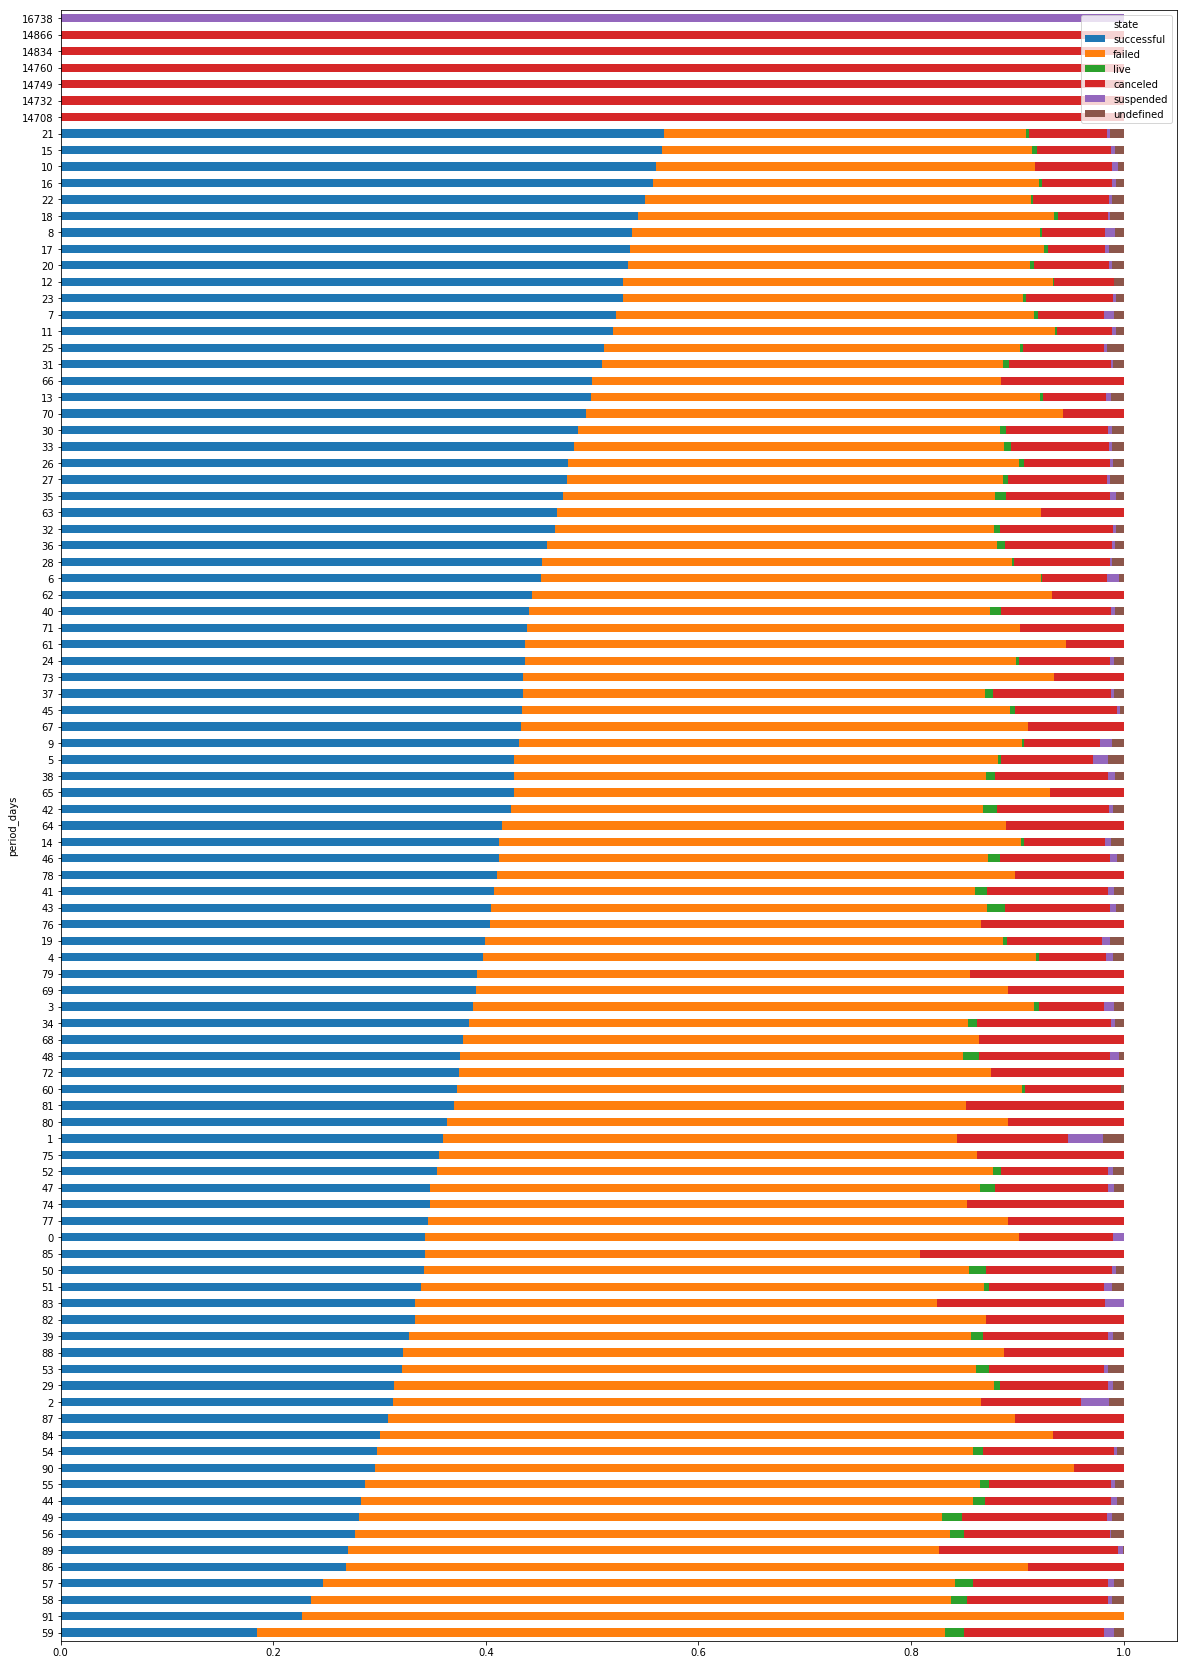

In [31]:
# 期限毎のstateを確認する
# 思ったより、期限とは比例していない。。。
period_days=df_kick.groupby('period_days')
period_days=period_days['state'].value_counts(normalize=True).unstack()
period_days=period_days.sort_values(by=['successful'],ascending=True)
period_days[['successful','failed','live','canceled','suspended','undefined']].plot(kind='barh',stacked=True,figsize=(20,30))

In [14]:
#期限だけでは、いまいち比例しなかったので
#日当たりの金額項目を新たに作成
df_kick['daily_goal'] = df_kick.goal / (df_kick.period_days + 1)

In [15]:
# state列の'successful'と'failed'以外を削除
df_kick = df_kick[(df_kick['state'] == 'successful') | (df_kick['state'] == 'failed')| (df_kick['state'] == 'canceld')]

In [16]:
# state列のsuccessfulをTrueにそれ以外をFalseに変換
df_kick["success"] = df_kick["state"] == "successful"

In [9]:
print(df_kick.groupby(by=["category"]).size())
print(df_kick.groupby(by=["main_category"]).size())
print(df_kick.groupby(by=["currency"]).size())
print(df_kick.groupby(by=["country"]).size())

category
3D Printing            568
Academic               777
Accessories           2740
Action                 621
Animals                229
Animation             2213
Anthologies            737
Apparel               6166
Apps                  5287
Architecture           642
Art                   7486
Art Books             2469
Audio                  363
Bacon                  181
Blues                  234
Calendars              290
Camera Equipment       350
Candles                378
Ceramics               275
Children's Books      6198
Childrenswear          418
Chiptune                33
Civic Design           266
Classical Music       2440
Comedy                2068
Comic Books           2493
Comics                4581
Community Gardens      271
Conceptual Art         930
Cookbooks              455
                     ...  
Shorts               11394
Small Batch           1621
Software              2573
Sound                  551
Space Exploration      283
Spaces             

In [17]:
#必要項目以外を削除
df_kick = df_kick[['daily_goal','main_category','currency','success']]

In [46]:
df_kick.head()

,daily_goal,main_category,currency,success
0,16.949153,Publishing,GBP,False
1,500.000000,Film & Video,USD,False
2,1000.000000,Film & Video,USD,False
3,166.666667,Music,USD,False
5,1428.571429,Food,USD,True


In [18]:
#Category, Currencyをダミー化(one-hot)
df_dummy = pd.get_dummies(df_kick, columns=["main_category","currency"], drop_first=True)
display(df_dummy.head())

,daily_goal,success,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,16.949153,False,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,500.000000,False,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1000.000000,False,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,166.666667,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,1428.571429,True,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [19]:
y = df_dummy["success"]
X = df_dummy.drop("success", axis=1)

In [20]:
#一般的には正規化の方が有効のようなので、正規化のみ検証

from sklearn.preprocessing import MinMaxScaler
mmsc = MinMaxScaler()
# 説明変数のデータを正規化する
x_train_norm = mmsc.fit_transform(X)

In [22]:
#ホールドアウト法


test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）



In [31]:

# 学習用データを使って線形回帰モデルを学習
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
clf.fit(X2_train, y2_train)

# テストデータに対する予測を実行
y_pred_test = clf.predict(X2_test) 
    
    
    
# 正答率を計算
accuracy =  accuracy_score(y2_test, y_pred_test)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
    
# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y2_test, y_pred_test)

# 成功に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
    
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y2_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
display(conf_mat)


正答率（Accuracy） = 60.276%
適合率（Precision） = 60.155%
再現率（Recall） = 99.726%
F1値（F1-score） = 75.044%


,予測 = 失敗,予測 = 成功
正解 = 失敗,39619,109
正解 = 成功,26242,365


In [32]:
#ぜんぶ失敗に予測されている為、パラメータか何かがおかしい。。
    
# ランダムフォレストを学習
clf = RandomForestClassifier(n_estimators=10, max_depth=2, criterion="gini",min_samples_leaf=2, min_samples_split=2, random_state=1234)
clf.fit(X2_train, y2_train)

# テストデータに対する予測を実行
y_pred_test = clf.predict(X2_test) 
    
    
    
# 正答率を計算
accuracy =  accuracy_score(y2_test, y_pred_test)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
    
# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y2_test, y_pred_test)

# 成功に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
    
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y2_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
display(conf_mat)
    




正答率（Accuracy） = 59.890%
適合率（Precision） = 59.890%
再現率（Recall） = 100.000%
F1値（F1-score） = 74.914%


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,予測 = 失敗,予測 = 成功
正解 = 失敗,39728,0
正解 = 成功,26607,0


In [28]:
# アダブーストを学習
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3,
                                                                                 min_samples_leaf=2,
                                                                                 min_samples_split=2, 
                                                                                 random_state=1234,
                                                                                 criterion="gini"),
                                           n_estimators=10, random_state=1234)
clf.fit(X2_train, y2_train)

# テストデータに対する予測を実行
y_pred_test = clf.predict(X2_test) 
    
    
    
# 正答率を計算
accuracy =  accuracy_score(y2_test, y_pred_test)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
    
# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y2_test, y_pred_test)

# 成功に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
    
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y2_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
display(conf_mat)


正答率（Accuracy） = 64.417%
適合率（Precision） = 66.524%
再現率（Recall） = 81.698%
F1値（F1-score） = 73.334%


,予測 = 失敗,予測 = 成功
正解 = 失敗,32457,7271
正解 = 成功,16333,10274


In [ ]:
#交差検証で５分割ロジスティクス回帰で実施
#なぜかエラーでさっぱり上手くいきません。。。

n_split = 5 # グループ数を設定（今回は5分割）

#cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
    clf.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = clf.predict(X_test) 
    
    
    
    # 正答率を計算
    print("Fold %s"%split_num)
    accuracy =  accuracy_score(y_test, y_pred_test)
    print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
    
    # Precision, Recall, F1-scoreを計算
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test)

    # 成功に関するPrecision, Recall, F1-scoreを表示
    print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
    print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
    print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
    
    # 予測値と正解のクロス集計（混同行列）
    conf_mat = confusion_matrix(y_test, y_pred_test)
    conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
    display(conf_mat)
    
    split_num += 1

In [ ]:
#交差検証で５分割ランダムフォレストで実施
#なぜかエラーでさっぱり上手くいきません。。。

n_split = 5 # グループ数を設定（今回は5分割）

#cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # ランダムフォレストを学習
    clf = RandomForestClassifier(n_estimators=10, max_depth=2, criterion="gini",min_samples_leaf=2, min_samples_split=2, random_state=1234)
    clf.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = clf.predict(X_test) 
    
    
    
    # 正答率を計算
    print("Fold %s"%split_num)
    accuracy =  accuracy_score(y_test, y_pred_test)
    print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
    
    # Precision, Recall, F1-scoreを計算
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test)

    # 成功に関するPrecision, Recall, F1-scoreを表示
    print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
    print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
    print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
    
    # 予測値と正解のクロス集計（混同行列）
    conf_mat = confusion_matrix(y_test, y_pred_test)
    conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
    display(conf_mat)
    
    split_num += 1




In [ ]:
#交差検証で５分割アダブーストで実施
#なぜかエラーでさっぱり上手くいきません。。。

n_split = 5 # グループ数を設定（今回は5分割）

#cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # ランダムフォレストを学習
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3,
                                                                                 min_samples_leaf=2,
                                                                                 min_samples_split=2, 
                                                                                 random_state=1234,
                                                                                 criterion="gini"),
                                           n_estimators=10, random_state=1234)
    clf.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = clf.predict(X_test) 
    
    
    
    # 正答率を計算
    print("Fold %s"%split_num)
    accuracy =  accuracy_score(y_test, y_pred_test)
    print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
    
    # Precision, Recall, F1-scoreを計算
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test)

    # 成功に関するPrecision, Recall, F1-scoreを表示
    print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
    print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
    print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
    
    # 予測値と正解のクロス集計（混同行列）
    conf_mat = confusion_matrix(y_test, y_pred_test)
    conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
    display(conf_mat)
    
    split_num += 1